# Error Mitigation

In [2]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [3]:
import os

register_config = [('NV', (0, 0, 0), 0, {})]
filename = os.path.join('NVcenter', 'data', 'dominik_bath_small')
directory = os.getcwd()

# create and save a new spinbath
# spin_type, abundancy, rmin, rmax, num_baths, num_init_states = 'C13', 0.5e-2, 0, 4e-9, 2, 100
# save_spin_baths(filename, directory, spin_type, abundancy, rmin, rmax, num_baths, num_init_states)

bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

In [4]:
xp, xm = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
yp, ym = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zp, zm = zp * zp.dag(), zm * zm.dag()
hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))

## Ramsey Protocol

In [12]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='no_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 2000)

miri_list = []
init_states = [xm, xp, ym, yp, zm, zp]
for init_state in init_states:
    env.old_register_state = hada * init_state * hada
    
    new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

    detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.0e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
    detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
    
    new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)] 
      
    sigmax = [ q.expect(state, q.sigmax()) for state in new_states ]
    sigmay = [ q.expect(state, q.sigmay()) for state in new_states ]
    sigmaz = [ q.expect(state, q.sigmaz()) for state in new_states ]
    miri_list.append( [sigmax, sigmay, sigmaz] )

miri_list = np.array(miri_list)
print(f"Shape: {miri_list.shape}")
np.save(f"export/0uT/{env.env_approx_level}", miri_list)
print(f'Saved as export/{env.env_approx_level}.npz')

Environment approximation level: no_bath
Shape: (6, 3, 2000)
Saved as export/no_bath.npz


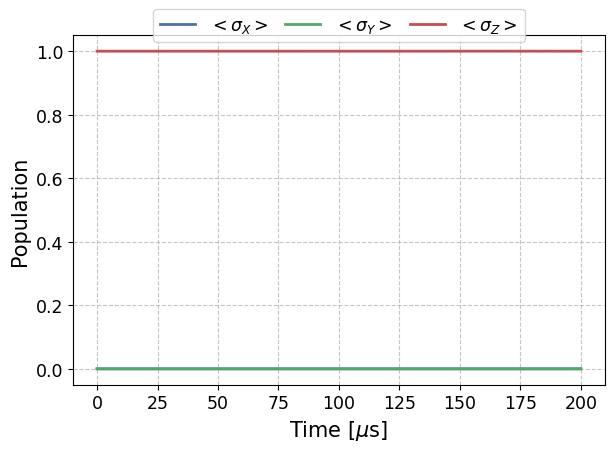

In [13]:
fig, ax = plt.subplots()

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

Environment approximation level: no_bath


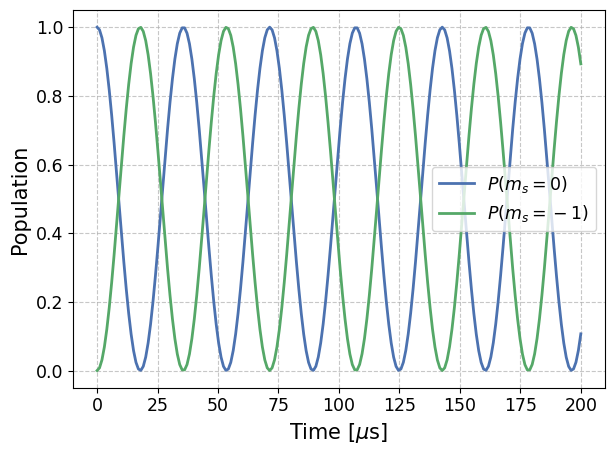

In [13]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='no_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 200)

env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.01e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

Environment approximation level: gCCE0


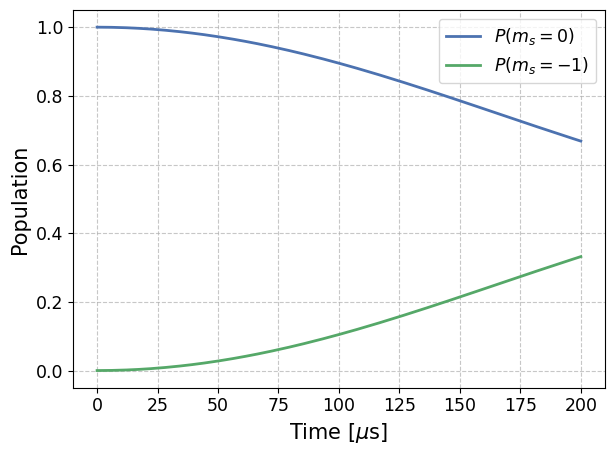

In [38]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='gCCE0', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 200)

env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.01e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

Environment approximation level: gCCE1


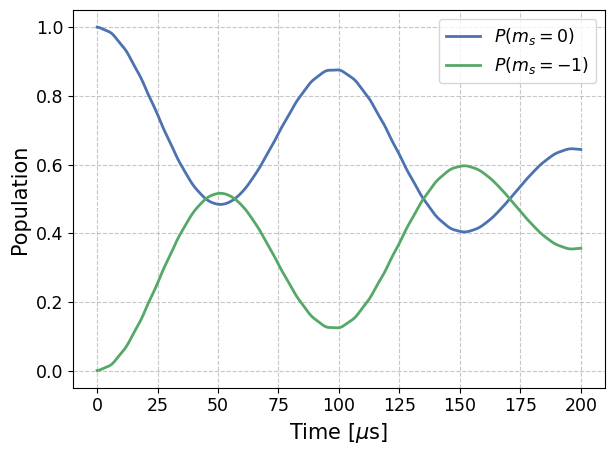

In [33]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='gCCE1', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 200)

env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

Environment approximation level: full_bath


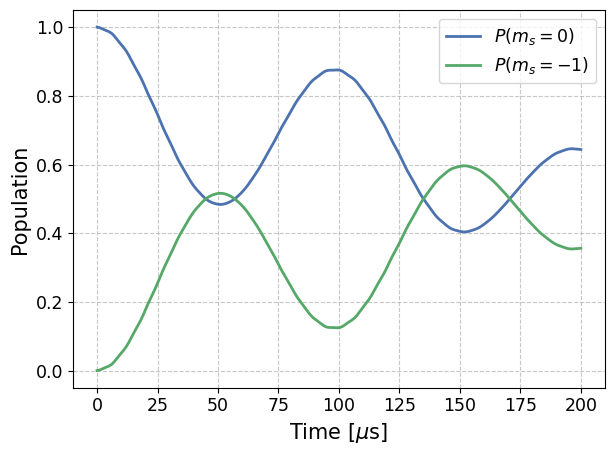

In [34]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='full_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 200)

env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()